<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:00:32] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


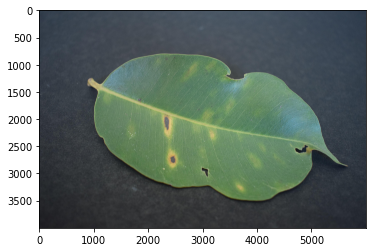

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

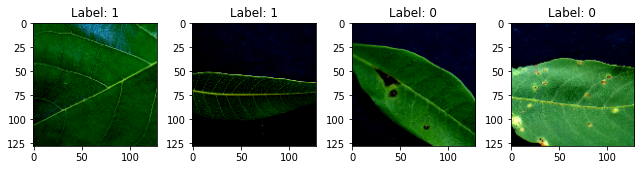

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:00:40] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:00:42] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2518843687717185 samples/sec                   batch loss = 0.5907893180847168 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2655558703626426 samples/sec                   batch loss = 0.839982807636261 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2640774195823317 samples/sec                   batch loss = 0.31606075167655945 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.270707024191975 samples/sec                   batch loss = 1.0617092847824097 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2764144665341703 samples/sec                   batch loss = 0.4872439503669739 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2733169125608284 samples/sec                   batch loss = 0.4054417908191681 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2771186102643786 samples/sec                   batch loss = 1.8520724773406982 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.2700822306526542 samples/sec                   batch loss = 0.4031292200088501 | accuracy = 0.61875


Epoch[1] Batch[45] Speed: 1.2768482096119853 samples/sec                   batch loss = 1.0734132528305054 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2752219068095911 samples/sec                   batch loss = 0.4520692527294159 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.2739884254360356 samples/sec                   batch loss = 0.6704371571540833 | accuracy = 0.5863636363636363


Epoch[1] Batch[60] Speed: 1.2750439708569907 samples/sec                   batch loss = 1.569475531578064 | accuracy = 0.5875


Epoch[1] Batch[65] Speed: 1.2748485505195832 samples/sec                   batch loss = 0.3661879003047943 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2796710806373088 samples/sec                   batch loss = 0.5867730379104614 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.27235173637715 samples/sec                   batch loss = 0.5687724947929382 | accuracy = 0.5966666666666667


Epoch[1] Batch[80] Speed: 1.2741066540439816 samples/sec                   batch loss = 0.4969708323478699 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2785306924575432 samples/sec                   batch loss = 0.5157083868980408 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.277723197707698 samples/sec                   batch loss = 0.48003292083740234 | accuracy = 0.6055555555555555


Epoch[1] Batch[95] Speed: 1.2775230641457265 samples/sec                   batch loss = 0.7990052700042725 | accuracy = 0.6


Epoch[1] Batch[100] Speed: 1.274429524088702 samples/sec                   batch loss = 0.7284640073776245 | accuracy = 0.6025


Epoch[1] Batch[105] Speed: 1.2773845543453244 samples/sec                   batch loss = 0.3663617670536041 | accuracy = 0.6095238095238096


Epoch[1] Batch[110] Speed: 1.2706643897954626 samples/sec                   batch loss = 0.3314868211746216 | accuracy = 0.6136363636363636


Epoch[1] Batch[115] Speed: 1.272195437398849 samples/sec                   batch loss = 0.438973605632782 | accuracy = 0.6195652173913043


Epoch[1] Batch[120] Speed: 1.2715766005329532 samples/sec                   batch loss = 0.31024202704429626 | accuracy = 0.6166666666666667


Epoch[1] Batch[125] Speed: 1.2736981715070927 samples/sec                   batch loss = 0.39312177896499634 | accuracy = 0.624


Epoch[1] Batch[130] Speed: 1.2694474853353728 samples/sec                   batch loss = 0.8581474423408508 | accuracy = 0.625


Epoch[1] Batch[135] Speed: 1.271613513294735 samples/sec                   batch loss = 0.23816028237342834 | accuracy = 0.6240740740740741


Epoch[1] Batch[140] Speed: 1.2700857881675283 samples/sec                   batch loss = 0.5475879907608032 | accuracy = 0.6232142857142857


Epoch[1] Batch[145] Speed: 1.2656387391361812 samples/sec                   batch loss = 0.34389254450798035 | accuracy = 0.6206896551724138


Epoch[1] Batch[150] Speed: 1.267405525037339 samples/sec                   batch loss = 0.7139744758605957 | accuracy = 0.6183333333333333


Epoch[1] Batch[155] Speed: 1.2706718963214154 samples/sec                   batch loss = 0.5584403276443481 | accuracy = 0.6193548387096774


Epoch[1] Batch[160] Speed: 1.2663308496399226 samples/sec                   batch loss = 0.4657581150531769 | accuracy = 0.625


Epoch[1] Batch[165] Speed: 1.2652432053159288 samples/sec                   batch loss = 0.1656140834093094 | accuracy = 0.6242424242424243


Epoch[1] Batch[170] Speed: 1.275685587584531 samples/sec                   batch loss = 0.4142731726169586 | accuracy = 0.6264705882352941


Epoch[1] Batch[175] Speed: 1.2646385473329187 samples/sec                   batch loss = 0.6193608641624451 | accuracy = 0.6285714285714286


Epoch[1] Batch[180] Speed: 1.2712163558590144 samples/sec                   batch loss = 0.47476911544799805 | accuracy = 0.6347222222222222


Epoch[1] Batch[185] Speed: 1.2717257104047155 samples/sec                   batch loss = 1.5066936016082764 | accuracy = 0.6324324324324324


Epoch[1] Batch[190] Speed: 1.2713124910584168 samples/sec                   batch loss = 0.4558326005935669 | accuracy = 0.6355263157894737


Epoch[1] Batch[195] Speed: 1.2753288279440356 samples/sec                   batch loss = 0.5702213048934937 | accuracy = 0.6423076923076924


Epoch[1] Batch[200] Speed: 1.2684348417183506 samples/sec                   batch loss = 0.929314911365509 | accuracy = 0.6425


Epoch[1] Batch[205] Speed: 1.2783570918874478 samples/sec                   batch loss = 0.7201347351074219 | accuracy = 0.6426829268292683


Epoch[1] Batch[210] Speed: 1.276739964817618 samples/sec                   batch loss = 0.4928654134273529 | accuracy = 0.6404761904761904


Epoch[1] Batch[215] Speed: 1.2717431586412649 samples/sec                   batch loss = 0.44756436347961426 | accuracy = 0.6395348837209303


Epoch[1] Batch[220] Speed: 1.2732960388457681 samples/sec                   batch loss = 0.34691208600997925 | accuracy = 0.6409090909090909


Epoch[1] Batch[225] Speed: 1.2707872962596751 samples/sec                   batch loss = 0.5709094405174255 | accuracy = 0.6388888888888888


Epoch[1] Batch[230] Speed: 1.2760206132060692 samples/sec                   batch loss = 0.8252432346343994 | accuracy = 0.6380434782608696


Epoch[1] Batch[235] Speed: 1.2763104702972745 samples/sec                   batch loss = 0.567256510257721 | accuracy = 0.6382978723404256


Epoch[1] Batch[240] Speed: 1.275094458529221 samples/sec                   batch loss = 1.5277841091156006 | accuracy = 0.640625


Epoch[1] Batch[245] Speed: 1.2723769214714575 samples/sec                   batch loss = 0.6775264143943787 | accuracy = 0.6418367346938776


Epoch[1] Batch[250] Speed: 1.2715554947209564 samples/sec                   batch loss = 0.558971643447876 | accuracy = 0.644


Epoch[1] Batch[255] Speed: 1.2775071106438494 samples/sec                   batch loss = 0.27953532338142395 | accuracy = 0.6470588235294118


Epoch[1] Batch[260] Speed: 1.2678070107759563 samples/sec                   batch loss = 0.5354301333427429 | accuracy = 0.6509615384615385


Epoch[1] Batch[265] Speed: 1.2749128766290512 samples/sec                   batch loss = 0.5282193422317505 | accuracy = 0.65


Epoch[1] Batch[270] Speed: 1.2708958818110074 samples/sec                   batch loss = 0.5549202561378479 | accuracy = 0.6518518518518519


Epoch[1] Batch[275] Speed: 1.2687594487406835 samples/sec                   batch loss = 0.8706211447715759 | accuracy = 0.6518181818181819


Epoch[1] Batch[280] Speed: 1.2724278736765464 samples/sec                   batch loss = 0.3006514012813568 | accuracy = 0.6526785714285714


Epoch[1] Batch[285] Speed: 1.2711839929711106 samples/sec                   batch loss = 0.7468569278717041 | accuracy = 0.6517543859649123


Epoch[1] Batch[290] Speed: 1.2706537075845166 samples/sec                   batch loss = 0.47313544154167175 | accuracy = 0.6525862068965518


Epoch[1] Batch[295] Speed: 1.2718227903737513 samples/sec                   batch loss = 0.26253896951675415 | accuracy = 0.6542372881355932


Epoch[1] Batch[300] Speed: 1.2686333847953635 samples/sec                   batch loss = 0.7105350494384766 | accuracy = 0.6533333333333333


Epoch[1] Batch[305] Speed: 1.2713470763144732 samples/sec                   batch loss = 0.3995150327682495 | accuracy = 0.6557377049180327


Epoch[1] Batch[310] Speed: 1.2699469637251137 samples/sec                   batch loss = 0.6073889136314392 | accuracy = 0.6564516129032258


Epoch[1] Batch[315] Speed: 1.2693031345414494 samples/sec                   batch loss = 0.7020203471183777 | accuracy = 0.6555555555555556


Epoch[1] Batch[320] Speed: 1.2713150921125147 samples/sec                   batch loss = 0.4045237898826599 | accuracy = 0.65625


Epoch[1] Batch[325] Speed: 1.2619109600411038 samples/sec                   batch loss = 0.44538772106170654 | accuracy = 0.6538461538461539


Epoch[1] Batch[330] Speed: 1.2663076237273874 samples/sec                   batch loss = 0.8853007555007935 | accuracy = 0.6545454545454545


Epoch[1] Batch[335] Speed: 1.2655788777702803 samples/sec                   batch loss = 0.45130524039268494 | accuracy = 0.6567164179104478


Epoch[1] Batch[340] Speed: 1.2665329414733733 samples/sec                   batch loss = 0.5275062322616577 | accuracy = 0.6595588235294118


Epoch[1] Batch[345] Speed: 1.2645625768011945 samples/sec                   batch loss = 0.400181382894516 | accuracy = 0.6594202898550725


Epoch[1] Batch[350] Speed: 1.2695303842298464 samples/sec                   batch loss = 0.623857855796814 | accuracy = 0.6607142857142857


Epoch[1] Batch[355] Speed: 1.266687947736752 samples/sec                   batch loss = 1.0951464176177979 | accuracy = 0.6598591549295775


Epoch[1] Batch[360] Speed: 1.2626536367486256 samples/sec                   batch loss = 0.4038681089878082 | accuracy = 0.6618055555555555


Epoch[1] Batch[365] Speed: 1.267905122287372 samples/sec                   batch loss = 0.7698621153831482 | accuracy = 0.6623287671232877


Epoch[1] Batch[370] Speed: 1.2678868210389873 samples/sec                   batch loss = 0.34056356549263 | accuracy = 0.6628378378378378


Epoch[1] Batch[375] Speed: 1.2648058672003355 samples/sec                   batch loss = 1.3647981882095337 | accuracy = 0.6633333333333333


Epoch[1] Batch[380] Speed: 1.2599148207316062 samples/sec                   batch loss = 0.4875952899456024 | accuracy = 0.6657894736842105


Epoch[1] Batch[385] Speed: 1.2659349786981282 samples/sec                   batch loss = 0.5170806050300598 | accuracy = 0.6662337662337663


Epoch[1] Batch[390] Speed: 1.2655955849183562 samples/sec                   batch loss = 1.0914870500564575 | accuracy = 0.6653846153846154


Epoch[1] Batch[395] Speed: 1.2664442196137127 samples/sec                   batch loss = 0.574806272983551 | accuracy = 0.6632911392405063


Epoch[1] Batch[400] Speed: 1.2665473790725916 samples/sec                   batch loss = 0.4761468470096588 | accuracy = 0.663125


Epoch[1] Batch[405] Speed: 1.2615438384787498 samples/sec                   batch loss = 0.3582243323326111 | accuracy = 0.6641975308641975


Epoch[1] Batch[410] Speed: 1.2636431711047384 samples/sec                   batch loss = 1.4547433853149414 | accuracy = 0.6646341463414634


Epoch[1] Batch[415] Speed: 1.2651213688743128 samples/sec                   batch loss = 0.6780370473861694 | accuracy = 0.6650602409638554


Epoch[1] Batch[420] Speed: 1.2633569455122677 samples/sec                   batch loss = 0.7292537689208984 | accuracy = 0.6642857142857143


Epoch[1] Batch[425] Speed: 1.260756420065976 samples/sec                   batch loss = 0.765044093132019 | accuracy = 0.6641176470588235


Epoch[1] Batch[430] Speed: 1.2684970835603473 samples/sec                   batch loss = 0.8421566486358643 | accuracy = 0.6651162790697674


Epoch[1] Batch[435] Speed: 1.2656646139832979 samples/sec                   batch loss = 0.5167007446289062 | accuracy = 0.6666666666666666


Epoch[1] Batch[440] Speed: 1.2670116611602678 samples/sec                   batch loss = 0.671972930431366 | accuracy = 0.66875


Epoch[1] Batch[445] Speed: 1.2685592355926962 samples/sec                   batch loss = 0.2780835032463074 | accuracy = 0.6691011235955057


Epoch[1] Batch[450] Speed: 1.2718464118731023 samples/sec                   batch loss = 0.568138599395752 | accuracy = 0.6688888888888889


Epoch[1] Batch[455] Speed: 1.2678012625254877 samples/sec                   batch loss = 0.9604953527450562 | accuracy = 0.6692307692307692


Epoch[1] Batch[460] Speed: 1.2681973430863158 samples/sec                   batch loss = 1.1124099493026733 | accuracy = 0.6690217391304348


Epoch[1] Batch[465] Speed: 1.2717637886657036 samples/sec                   batch loss = 0.513950526714325 | accuracy = 0.6661290322580645


Epoch[1] Batch[470] Speed: 1.269391393036407 samples/sec                   batch loss = 0.4353472590446472 | accuracy = 0.6659574468085107


Epoch[1] Batch[475] Speed: 1.2652859538098515 samples/sec                   batch loss = 0.7687655091285706 | accuracy = 0.6642105263157895


Epoch[1] Batch[480] Speed: 1.2723167104897548 samples/sec                   batch loss = 0.5436176657676697 | accuracy = 0.6645833333333333


Epoch[1] Batch[485] Speed: 1.273311983983054 samples/sec                   batch loss = 0.6266667246818542 | accuracy = 0.6634020618556701


Epoch[1] Batch[490] Speed: 1.270995242295074 samples/sec                   batch loss = 0.5851653218269348 | accuracy = 0.6637755102040817


Epoch[1] Batch[495] Speed: 1.2719518033742643 samples/sec                   batch loss = 0.7192702293395996 | accuracy = 0.6636363636363637


Epoch[1] Batch[500] Speed: 1.2646402632094298 samples/sec                   batch loss = 0.34135904908180237 | accuracy = 0.6635


Epoch[1] Batch[505] Speed: 1.2684301426593187 samples/sec                   batch loss = 0.8440771698951721 | accuracy = 0.6643564356435644


Epoch[1] Batch[510] Speed: 1.2691726420222742 samples/sec                   batch loss = 0.3198336958885193 | accuracy = 0.6651960784313725


Epoch[1] Batch[515] Speed: 1.26596774355417 samples/sec                   batch loss = 0.32520362734794617 | accuracy = 0.6660194174757281


Epoch[1] Batch[520] Speed: 1.268074841226255 samples/sec                   batch loss = 0.510057270526886 | accuracy = 0.666826923076923


Epoch[1] Batch[525] Speed: 1.265682946618621 samples/sec                   batch loss = 0.8799787163734436 | accuracy = 0.6671428571428571


Epoch[1] Batch[530] Speed: 1.262148863339633 samples/sec                   batch loss = 0.6472471952438354 | accuracy = 0.6669811320754717


Epoch[1] Batch[535] Speed: 1.2684381023103846 samples/sec                   batch loss = 0.26367494463920593 | accuracy = 0.6677570093457944


Epoch[1] Batch[540] Speed: 1.262845240936735 samples/sec                   batch loss = 0.47775548696517944 | accuracy = 0.6675925925925926


Epoch[1] Batch[545] Speed: 1.2637252184392889 samples/sec                   batch loss = 0.9445934891700745 | accuracy = 0.6669724770642201


Epoch[1] Batch[550] Speed: 1.2600629114566537 samples/sec                   batch loss = 0.6474420428276062 | accuracy = 0.6668181818181819


Epoch[1] Batch[555] Speed: 1.261361448367435 samples/sec                   batch loss = 0.2805224359035492 | accuracy = 0.6671171171171171


Epoch[1] Batch[560] Speed: 1.2625864559939688 samples/sec                   batch loss = 0.4848243296146393 | accuracy = 0.6660714285714285


Epoch[1] Batch[565] Speed: 1.264862413209104 samples/sec                   batch loss = 0.5755167007446289 | accuracy = 0.6672566371681415


Epoch[1] Batch[570] Speed: 1.2625132969677195 samples/sec                   batch loss = 0.553214430809021 | accuracy = 0.6671052631578948


Epoch[1] Batch[575] Speed: 1.2644545942514898 samples/sec                   batch loss = 0.3989853858947754 | accuracy = 0.6673913043478261


Epoch[1] Batch[580] Speed: 1.2651182207103302 samples/sec                   batch loss = 0.4616726040840149 | accuracy = 0.6676724137931035


Epoch[1] Batch[585] Speed: 1.2625259329210554 samples/sec                   batch loss = 0.42649948596954346 | accuracy = 0.6696581196581196


Epoch[1] Batch[590] Speed: 1.259040706932837 samples/sec                   batch loss = 0.6430142521858215 | accuracy = 0.6703389830508475


Epoch[1] Batch[595] Speed: 1.2675118097232172 samples/sec                   batch loss = 1.334558367729187 | accuracy = 0.6697478991596638


Epoch[1] Batch[600] Speed: 1.2604829592816729 samples/sec                   batch loss = 0.3948139250278473 | accuracy = 0.6695833333333333


Epoch[1] Batch[605] Speed: 1.2611761720229067 samples/sec                   batch loss = 0.35958078503608704 | accuracy = 0.6710743801652893


Epoch[1] Batch[610] Speed: 1.2644095196142233 samples/sec                   batch loss = 1.0685741901397705 | accuracy = 0.671311475409836


Epoch[1] Batch[615] Speed: 1.2593337709456216 samples/sec                   batch loss = 0.33421480655670166 | accuracy = 0.6715447154471544


Epoch[1] Batch[620] Speed: 1.2722042161383211 samples/sec                   batch loss = 0.6925656795501709 | accuracy = 0.6717741935483871


Epoch[1] Batch[625] Speed: 1.2666277002030413 samples/sec                   batch loss = 0.7130780220031738 | accuracy = 0.672


Epoch[1] Batch[630] Speed: 1.2659671703934257 samples/sec                   batch loss = 0.774796724319458 | accuracy = 0.6730158730158731


Epoch[1] Batch[635] Speed: 1.2597913595509533 samples/sec                   batch loss = 0.4590226709842682 | accuracy = 0.6736220472440945


Epoch[1] Batch[640] Speed: 1.2644788005626735 samples/sec                   batch loss = 0.2488028109073639 | accuracy = 0.673828125


Epoch[1] Batch[645] Speed: 1.26467810900304 samples/sec                   batch loss = 0.2899523079395294 | accuracy = 0.6759689922480621


Epoch[1] Batch[650] Speed: 1.2610859240434207 samples/sec                   batch loss = 0.23730425536632538 | accuracy = 0.6784615384615384


Epoch[1] Batch[655] Speed: 1.2613281628841844 samples/sec                   batch loss = 0.9630144834518433 | accuracy = 0.6786259541984733


Epoch[1] Batch[660] Speed: 1.261393028526799 samples/sec                   batch loss = 0.5211029052734375 | accuracy = 0.6795454545454546


Epoch[1] Batch[665] Speed: 1.2569694337918962 samples/sec                   batch loss = 1.0396552085876465 | accuracy = 0.6785714285714286


Epoch[1] Batch[670] Speed: 1.2654302513057667 samples/sec                   batch loss = 0.564022421836853 | accuracy = 0.6783582089552239


Epoch[1] Batch[675] Speed: 1.2598529452072025 samples/sec                   batch loss = 0.8707226514816284 | accuracy = 0.677037037037037


Epoch[1] Batch[680] Speed: 1.2622514191587542 samples/sec                   batch loss = 0.50563645362854 | accuracy = 0.6772058823529412


Epoch[1] Batch[685] Speed: 1.2632871215797112 samples/sec                   batch loss = 0.8106900453567505 | accuracy = 0.6781021897810219


Epoch[1] Batch[690] Speed: 1.2574287924626895 samples/sec                   batch loss = 0.39343416690826416 | accuracy = 0.6793478260869565


Epoch[1] Batch[695] Speed: 1.2625788546614878 samples/sec                   batch loss = 1.009478211402893 | accuracy = 0.6798561151079137


Epoch[1] Batch[700] Speed: 1.267310362706551 samples/sec                   batch loss = 0.4485999643802643 | accuracy = 0.68


Epoch[1] Batch[705] Speed: 1.2693436608574091 samples/sec                   batch loss = 0.23833797872066498 | accuracy = 0.6804964539007092


Epoch[1] Batch[710] Speed: 1.2685301730046614 samples/sec                   batch loss = 0.5668891072273254 | accuracy = 0.6806338028169014


Epoch[1] Batch[715] Speed: 1.2629409697683962 samples/sec                   batch loss = 0.48407724499702454 | accuracy = 0.6807692307692308


Epoch[1] Batch[720] Speed: 1.2584020337591233 samples/sec                   batch loss = 0.5341498851776123 | accuracy = 0.6805555555555556


Epoch[1] Batch[725] Speed: 1.2598503908437082 samples/sec                   batch loss = 1.2567671537399292 | accuracy = 0.6806896551724138


Epoch[1] Batch[730] Speed: 1.2634099369447802 samples/sec                   batch loss = 1.1095341444015503 | accuracy = 0.6808219178082192


Epoch[1] Batch[735] Speed: 1.2609413835528822 samples/sec                   batch loss = 0.5281192660331726 | accuracy = 0.6812925170068027


Epoch[1] Batch[740] Speed: 1.2672330179403652 samples/sec                   batch loss = 0.6760269403457642 | accuracy = 0.6804054054054054


Epoch[1] Batch[745] Speed: 1.2673851319062233 samples/sec                   batch loss = 0.459199994802475 | accuracy = 0.6802013422818792


Epoch[1] Batch[750] Speed: 1.26694602503351 samples/sec                   batch loss = 0.7947481274604797 | accuracy = 0.6803333333333333


Epoch[1] Batch[755] Speed: 1.2657198999507961 samples/sec                   batch loss = 0.7939948439598083 | accuracy = 0.6794701986754967


Epoch[1] Batch[760] Speed: 1.2668343826974564 samples/sec                   batch loss = 0.49266526103019714 | accuracy = 0.6805921052631579


Epoch[1] Batch[765] Speed: 1.2657025211123736 samples/sec                   batch loss = 1.1230448484420776 | accuracy = 0.6803921568627451


Epoch[1] Batch[770] Speed: 1.2683134445466437 samples/sec                   batch loss = 0.26354944705963135 | accuracy = 0.6805194805194805


Epoch[1] Batch[775] Speed: 1.2645717270969201 samples/sec                   batch loss = 0.744314968585968 | accuracy = 0.6796774193548387


Epoch[1] Batch[780] Speed: 1.2642810792904353 samples/sec                   batch loss = 0.41517534852027893 | accuracy = 0.6810897435897436


Epoch[1] Batch[785] Speed: 1.2639202901984496 samples/sec                   batch loss = 0.32647737860679626 | accuracy = 0.6821656050955414


[Epoch 1] training: accuracy=0.682741116751269
[Epoch 1] time cost: 649.3928837776184
[Epoch 1] validation: validation accuracy=0.7455555555555555


Epoch[2] Batch[5] Speed: 1.2656322467206538 samples/sec                   batch loss = 1.3997269868850708 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.270397484589331 samples/sec                   batch loss = 0.5716041922569275 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2665959530149307 samples/sec                   batch loss = 0.5728069543838501 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2621835215437365 samples/sec                   batch loss = 0.5617864727973938 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.2603753882513973 samples/sec                   batch loss = 0.5548453330993652 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2662990217537664 samples/sec                   batch loss = 0.25977587699890137 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2665626775501428 samples/sec                   batch loss = 0.4502115249633789 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2683671402714953 samples/sec                   batch loss = 0.28079164028167725 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2676877452585673 samples/sec                   batch loss = 0.2771911025047302 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.269219881248484 samples/sec                   batch loss = 0.11779213696718216 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2715430628582256 samples/sec                   batch loss = 0.2282233089208603 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.26983248523764 samples/sec                   batch loss = 0.6603626012802124 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.2650709047391326 samples/sec                   batch loss = 0.7792196869850159 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.269910628266513 samples/sec                   batch loss = 0.40307071805000305 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.265881584214146 samples/sec                   batch loss = 0.6530013084411621 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2695695800606663 samples/sec                   batch loss = 0.29423704743385315 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.268173377636564 samples/sec                   batch loss = 0.5671886205673218 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.2711903498369 samples/sec                   batch loss = 1.4340031147003174 | accuracy = 0.7333333333333333


Epoch[2] Batch[95] Speed: 1.2635833080210712 samples/sec                   batch loss = 0.5465668439865112 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.2605332474605957 samples/sec                   batch loss = 0.46399012207984924 | accuracy = 0.73


Epoch[2] Batch[105] Speed: 1.25655774717383 samples/sec                   batch loss = 0.4103510081768036 | accuracy = 0.7333333333333333


Epoch[2] Batch[110] Speed: 1.26471328760312 samples/sec                   batch loss = 0.3966551125049591 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.2575248329286923 samples/sec                   batch loss = 0.5648243427276611 | accuracy = 0.741304347826087


Epoch[2] Batch[120] Speed: 1.262836590883396 samples/sec                   batch loss = 0.6119233965873718 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2604293608570238 samples/sec                   batch loss = 0.7504986524581909 | accuracy = 0.736


Epoch[2] Batch[130] Speed: 1.2597630756835518 samples/sec                   batch loss = 0.38594838976860046 | accuracy = 0.7326923076923076


Epoch[2] Batch[135] Speed: 1.2659962111908338 samples/sec                   batch loss = 0.5955401062965393 | accuracy = 0.7277777777777777


Epoch[2] Batch[140] Speed: 1.2581247815445211 samples/sec                   batch loss = 0.3543802797794342 | accuracy = 0.7267857142857143


Epoch[2] Batch[145] Speed: 1.259499595399316 samples/sec                   batch loss = 0.23209945857524872 | accuracy = 0.7293103448275862


Epoch[2] Batch[150] Speed: 1.2621405076738164 samples/sec                   batch loss = 0.19565756618976593 | accuracy = 0.73


Epoch[2] Batch[155] Speed: 1.2620669256213815 samples/sec                   batch loss = 0.6924103498458862 | accuracy = 0.7322580645161291


Epoch[2] Batch[160] Speed: 1.2596309434714763 samples/sec                   batch loss = 0.7221166491508484 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.2645386532162146 samples/sec                   batch loss = 0.13627906143665314 | accuracy = 0.7333333333333333


Epoch[2] Batch[170] Speed: 1.2618121606530863 samples/sec                   batch loss = 0.13933688402175903 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.2627635929553496 samples/sec                   batch loss = 0.6470212936401367 | accuracy = 0.7314285714285714


Epoch[2] Batch[180] Speed: 1.2568793160423068 samples/sec                   batch loss = 0.17864808440208435 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2681135638256462 samples/sec                   batch loss = 0.4396030604839325 | accuracy = 0.7378378378378379


Epoch[2] Batch[190] Speed: 1.2636211857520316 samples/sec                   batch loss = 0.39116400480270386 | accuracy = 0.7394736842105263


Epoch[2] Batch[195] Speed: 1.261817854722163 samples/sec                   batch loss = 0.13319967687129974 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.2691737941566863 samples/sec                   batch loss = 0.5041019916534424 | accuracy = 0.74375


Epoch[2] Batch[205] Speed: 1.2687486066405131 samples/sec                   batch loss = 0.3724360466003418 | accuracy = 0.7451219512195122


Epoch[2] Batch[210] Speed: 1.265519881199408 samples/sec                   batch loss = 0.5159720182418823 | accuracy = 0.7476190476190476


Epoch[2] Batch[215] Speed: 1.2695608376435947 samples/sec                   batch loss = 0.2312227189540863 | accuracy = 0.7476744186046511


Epoch[2] Batch[220] Speed: 1.269830947463947 samples/sec                   batch loss = 0.5861876010894775 | accuracy = 0.7488636363636364


Epoch[2] Batch[225] Speed: 1.2685678683011072 samples/sec                   batch loss = 0.6683251857757568 | accuracy = 0.7477777777777778


Epoch[2] Batch[230] Speed: 1.2703992161290236 samples/sec                   batch loss = 0.19096924364566803 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.2687203988587183 samples/sec                   batch loss = 0.6358708143234253 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.264735978361737 samples/sec                   batch loss = 0.5100340843200684 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.2676519220882765 samples/sec                   batch loss = 0.3234935700893402 | accuracy = 0.7479591836734694


Epoch[2] Batch[250] Speed: 1.2637830958212006 samples/sec                   batch loss = 0.5057332515716553 | accuracy = 0.75


Epoch[2] Batch[255] Speed: 1.2658188347373578 samples/sec                   batch loss = 0.5400021076202393 | accuracy = 0.75


Epoch[2] Batch[260] Speed: 1.2711692568449389 samples/sec                   batch loss = 0.4092751145362854 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2656150612363626 samples/sec                   batch loss = 0.6021087169647217 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2609692464856863 samples/sec                   batch loss = 0.5813276767730713 | accuracy = 0.7453703703703703


Epoch[2] Batch[275] Speed: 1.2622204607387684 samples/sec                   batch loss = 0.45637476444244385 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2645591454744372 samples/sec                   batch loss = 0.5727279782295227 | accuracy = 0.7464285714285714


Epoch[2] Batch[285] Speed: 1.267556818520945 samples/sec                   batch loss = 0.5354392528533936 | accuracy = 0.7447368421052631


Epoch[2] Batch[290] Speed: 1.260567911705331 samples/sec                   batch loss = 0.4902859032154083 | accuracy = 0.7448275862068966


Epoch[2] Batch[295] Speed: 1.2634086049692126 samples/sec                   batch loss = 0.18172520399093628 | accuracy = 0.7466101694915255


Epoch[2] Batch[300] Speed: 1.2624104136193797 samples/sec                   batch loss = 0.5868250131607056 | accuracy = 0.7433333333333333


Epoch[2] Batch[305] Speed: 1.269453824845321 samples/sec                   batch loss = 0.5930941104888916 | accuracy = 0.7434426229508196


Epoch[2] Batch[310] Speed: 1.2624618056982144 samples/sec                   batch loss = 0.9387723207473755 | accuracy = 0.7435483870967742


Epoch[2] Batch[315] Speed: 1.262723675782917 samples/sec                   batch loss = 0.6033225655555725 | accuracy = 0.7404761904761905


Epoch[2] Batch[320] Speed: 1.2581056294196606 samples/sec                   batch loss = 0.25095993280410767 | accuracy = 0.740625


Epoch[2] Batch[325] Speed: 1.2575244559011256 samples/sec                   batch loss = 0.4807680547237396 | accuracy = 0.7423076923076923


Epoch[2] Batch[330] Speed: 1.2586601447549313 samples/sec                   batch loss = 0.35809677839279175 | accuracy = 0.7424242424242424


Epoch[2] Batch[335] Speed: 1.2623144802693766 samples/sec                   batch loss = 0.5788429379463196 | accuracy = 0.744776119402985


Epoch[2] Batch[340] Speed: 1.2628466667810794 samples/sec                   batch loss = 0.511309802532196 | accuracy = 0.7433823529411765


Epoch[2] Batch[345] Speed: 1.2588405265347666 samples/sec                   batch loss = 0.3451964855194092 | accuracy = 0.744927536231884


Epoch[2] Batch[350] Speed: 1.2598576755373212 samples/sec                   batch loss = 0.23311544954776764 | accuracy = 0.7464285714285714


Epoch[2] Batch[355] Speed: 1.2652516021135471 samples/sec                   batch loss = 0.5342275500297546 | accuracy = 0.7464788732394366


Epoch[2] Batch[360] Speed: 1.267901768615932 samples/sec                   batch loss = 0.988070011138916 | accuracy = 0.7465277777777778


Epoch[2] Batch[365] Speed: 1.2634200219937832 samples/sec                   batch loss = 0.9337136149406433 | accuracy = 0.7452054794520548


Epoch[2] Batch[370] Speed: 1.2618249723807766 samples/sec                   batch loss = 0.4824844002723694 | accuracy = 0.7452702702702703


Epoch[2] Batch[375] Speed: 1.2620909456578184 samples/sec                   batch loss = 0.8101198077201843 | accuracy = 0.7453333333333333


Epoch[2] Batch[380] Speed: 1.2627367911469118 samples/sec                   batch loss = 0.37814074754714966 | accuracy = 0.7473684210526316


Epoch[2] Batch[385] Speed: 1.2722203268874848 samples/sec                   batch loss = 0.2562505602836609 | accuracy = 0.7467532467532467


Epoch[2] Batch[390] Speed: 1.2658124359774015 samples/sec                   batch loss = 0.8243293762207031 | accuracy = 0.7455128205128205


Epoch[2] Batch[395] Speed: 1.2713684642389502 samples/sec                   batch loss = 0.2649952173233032 | accuracy = 0.7455696202531645


Epoch[2] Batch[400] Speed: 1.2703488110159185 samples/sec                   batch loss = 0.45410674810409546 | accuracy = 0.74375


Epoch[2] Batch[405] Speed: 1.2649321252810286 samples/sec                   batch loss = 0.2982994318008423 | accuracy = 0.7450617283950617


Epoch[2] Batch[410] Speed: 1.2664870493043394 samples/sec                   batch loss = 0.7055940628051758 | accuracy = 0.7451219512195122


Epoch[2] Batch[415] Speed: 1.271000634393651 samples/sec                   batch loss = 0.6509086489677429 | accuracy = 0.744578313253012


Epoch[2] Batch[420] Speed: 1.2637414959171287 samples/sec                   batch loss = 0.3511148989200592 | accuracy = 0.7464285714285714


Epoch[2] Batch[425] Speed: 1.271972825909367 samples/sec                   batch loss = 1.2788221836090088 | accuracy = 0.7470588235294118


Epoch[2] Batch[430] Speed: 1.265639884863483 samples/sec                   batch loss = 0.3450104594230652 | accuracy = 0.7488372093023256


Epoch[2] Batch[435] Speed: 1.2666508422285399 samples/sec                   batch loss = 0.4954409897327423 | accuracy = 0.7488505747126437


Epoch[2] Batch[440] Speed: 1.2667453316690258 samples/sec                   batch loss = 0.4078029692173004 | accuracy = 0.7471590909090909


Epoch[2] Batch[445] Speed: 1.2692870015623596 samples/sec                   batch loss = 0.6814820766448975 | accuracy = 0.7460674157303371


Epoch[2] Batch[450] Speed: 1.2754605895202233 samples/sec                   batch loss = 0.7745051383972168 | accuracy = 0.7455555555555555


Epoch[2] Batch[455] Speed: 1.276207364710221 samples/sec                   batch loss = 0.3675556480884552 | accuracy = 0.7461538461538462


Epoch[2] Batch[460] Speed: 1.2738574514386538 samples/sec                   batch loss = 0.2789009213447571 | accuracy = 0.7456521739130435


Epoch[2] Batch[465] Speed: 1.2714296453835352 samples/sec                   batch loss = 1.0015339851379395 | accuracy = 0.7462365591397849


Epoch[2] Batch[470] Speed: 1.2748918536774005 samples/sec                   batch loss = 0.22265759110450745 | accuracy = 0.7473404255319149


Epoch[2] Batch[475] Speed: 1.2752089185186424 samples/sec                   batch loss = 0.4000512361526489 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.2726396392446457 samples/sec                   batch loss = 0.12609826028347015 | accuracy = 0.7505208333333333


Epoch[2] Batch[485] Speed: 1.2774967021714347 samples/sec                   batch loss = 0.32271507382392883 | accuracy = 0.7510309278350515


Epoch[2] Batch[490] Speed: 1.2774184981400503 samples/sec                   batch loss = 0.48684361577033997 | accuracy = 0.7520408163265306


Epoch[2] Batch[495] Speed: 1.2711968030838685 samples/sec                   batch loss = 0.4018251299858093 | accuracy = 0.7525252525252525


Epoch[2] Batch[500] Speed: 1.2719228744161963 samples/sec                   batch loss = 0.7695616483688354 | accuracy = 0.752


Epoch[2] Batch[505] Speed: 1.2792444891669739 samples/sec                   batch loss = 0.48589181900024414 | accuracy = 0.7504950495049505


Epoch[2] Batch[510] Speed: 1.272298281664876 samples/sec                   batch loss = 0.8180633783340454 | accuracy = 0.75


Epoch[2] Batch[515] Speed: 1.261503618965696 samples/sec                   batch loss = 0.9699571132659912 | accuracy = 0.7495145631067961


Epoch[2] Batch[520] Speed: 1.2663718554912973 samples/sec                   batch loss = 1.308401346206665 | accuracy = 0.7485576923076923


Epoch[2] Batch[525] Speed: 1.2664190776402955 samples/sec                   batch loss = 0.41871151328086853 | accuracy = 0.7490476190476191


Epoch[2] Batch[530] Speed: 1.262849043195475 samples/sec                   batch loss = 0.36266979575157166 | accuracy = 0.7490566037735849


Epoch[2] Batch[535] Speed: 1.2688573238716432 samples/sec                   batch loss = 0.568522036075592 | accuracy = 0.747196261682243


Epoch[2] Batch[540] Speed: 1.267617633356539 samples/sec                   batch loss = 0.4033114016056061 | accuracy = 0.7486111111111111


Epoch[2] Batch[545] Speed: 1.2684087575855378 samples/sec                   batch loss = 0.3756563663482666 | accuracy = 0.7490825688073395


Epoch[2] Batch[550] Speed: 1.269556130238119 samples/sec                   batch loss = 0.6454507112503052 | accuracy = 0.7490909090909091


Epoch[2] Batch[555] Speed: 1.2725134787076127 samples/sec                   batch loss = 0.30578792095184326 | accuracy = 0.7504504504504504


Epoch[2] Batch[560] Speed: 1.2673075865553063 samples/sec                   batch loss = 0.21417935192584991 | accuracy = 0.7495535714285714


Epoch[2] Batch[565] Speed: 1.2694010935760598 samples/sec                   batch loss = 0.9630615711212158 | accuracy = 0.7495575221238938


Epoch[2] Batch[570] Speed: 1.2626532566393807 samples/sec                   batch loss = 0.2850738763809204 | accuracy = 0.749561403508772


Epoch[2] Batch[575] Speed: 1.2674244826210517 samples/sec                   batch loss = 0.32523781061172485 | accuracy = 0.7504347826086957


Epoch[2] Batch[580] Speed: 1.2725882839644411 samples/sec                   batch loss = 0.5501113533973694 | accuracy = 0.7508620689655172


Epoch[2] Batch[585] Speed: 1.2662671954674904 samples/sec                   batch loss = 0.32242292165756226 | accuracy = 0.7504273504273504


Epoch[2] Batch[590] Speed: 1.260681957263755 samples/sec                   batch loss = 0.495190292596817 | accuracy = 0.75


Epoch[2] Batch[595] Speed: 1.2649092367494037 samples/sec                   batch loss = 0.4045466482639313 | accuracy = 0.75


Epoch[2] Batch[600] Speed: 1.2599001554935731 samples/sec                   batch loss = 0.628582239151001 | accuracy = 0.75


Epoch[2] Batch[605] Speed: 1.2645747772249223 samples/sec                   batch loss = 1.1770412921905518 | accuracy = 0.7495867768595041


Epoch[2] Batch[610] Speed: 1.2596861764718248 samples/sec                   batch loss = 0.23181533813476562 | accuracy = 0.7491803278688525


Epoch[2] Batch[615] Speed: 1.2620376850719044 samples/sec                   batch loss = 0.32014548778533936 | accuracy = 0.75


Epoch[2] Batch[620] Speed: 1.2644684127014394 samples/sec                   batch loss = 0.34658920764923096 | accuracy = 0.7504032258064516


Epoch[2] Batch[625] Speed: 1.2576743421770207 samples/sec                   batch loss = 0.5172488689422607 | accuracy = 0.7516


Epoch[2] Batch[630] Speed: 1.2638540218809584 samples/sec                   batch loss = 1.0982801914215088 | accuracy = 0.751984126984127


Epoch[2] Batch[635] Speed: 1.2616178339044393 samples/sec                   batch loss = 0.28512459993362427 | accuracy = 0.7535433070866142


Epoch[2] Batch[640] Speed: 1.2612173187708473 samples/sec                   batch loss = 0.22137795388698578 | accuracy = 0.75390625


Epoch[2] Batch[645] Speed: 1.2654899077027193 samples/sec                   batch loss = 0.37265467643737793 | accuracy = 0.7542635658914729


Epoch[2] Batch[650] Speed: 1.2696340470950447 samples/sec                   batch loss = 0.7351871132850647 | accuracy = 0.7538461538461538


Epoch[2] Batch[655] Speed: 1.2636923791902064 samples/sec                   batch loss = 0.12447697669267654 | accuracy = 0.7534351145038168


Epoch[2] Batch[660] Speed: 1.2661614060678366 samples/sec                   batch loss = 0.18879103660583496 | accuracy = 0.7537878787878788


Epoch[2] Batch[665] Speed: 1.2677660077295174 samples/sec                   batch loss = 0.41685450077056885 | accuracy = 0.7533834586466165


Epoch[2] Batch[670] Speed: 1.266945163963339 samples/sec                   batch loss = 1.2110636234283447 | accuracy = 0.7533582089552239


Epoch[2] Batch[675] Speed: 1.2557600899626713 samples/sec                   batch loss = 0.1395227015018463 | accuracy = 0.7522222222222222


Epoch[2] Batch[680] Speed: 1.260454928441536 samples/sec                   batch loss = 0.31817626953125 | accuracy = 0.7529411764705882


Epoch[2] Batch[685] Speed: 1.2622606310063256 samples/sec                   batch loss = 1.6830581426620483 | accuracy = 0.7521897810218978


Epoch[2] Batch[690] Speed: 1.2610909480136852 samples/sec                   batch loss = 0.3166937232017517 | accuracy = 0.7518115942028986


Epoch[2] Batch[695] Speed: 1.2565727111602172 samples/sec                   batch loss = 1.1623984575271606 | accuracy = 0.7521582733812949


Epoch[2] Batch[700] Speed: 1.2594844670712149 samples/sec                   batch loss = 0.6660611033439636 | accuracy = 0.7532142857142857


Epoch[2] Batch[705] Speed: 1.261030473445943 samples/sec                   batch loss = 0.5379558205604553 | accuracy = 0.7524822695035461


Epoch[2] Batch[710] Speed: 1.2552409957613249 samples/sec                   batch loss = 0.6685110926628113 | accuracy = 0.7524647887323944


Epoch[2] Batch[715] Speed: 1.2593182684968294 samples/sec                   batch loss = 0.3692814111709595 | accuracy = 0.7531468531468531


Epoch[2] Batch[720] Speed: 1.2667996599158247 samples/sec                   batch loss = 0.7748675346374512 | accuracy = 0.7541666666666667


Epoch[2] Batch[725] Speed: 1.2719039748742877 samples/sec                   batch loss = 0.3416835367679596 | accuracy = 0.753448275862069


Epoch[2] Batch[730] Speed: 1.270586346427795 samples/sec                   batch loss = 0.28755152225494385 | accuracy = 0.7544520547945206


Epoch[2] Batch[735] Speed: 1.2717444118479542 samples/sec                   batch loss = 0.5166057348251343 | accuracy = 0.7547619047619047


Epoch[2] Batch[740] Speed: 1.2657186585893676 samples/sec                   batch loss = 0.30194398760795593 | accuracy = 0.7543918918918919


Epoch[2] Batch[745] Speed: 1.2614903395009744 samples/sec                   batch loss = 0.3538046181201935 | accuracy = 0.7543624161073825


Epoch[2] Batch[750] Speed: 1.2659444354358163 samples/sec                   batch loss = 0.7198891043663025 | accuracy = 0.7533333333333333


Epoch[2] Batch[755] Speed: 1.2678503159383063 samples/sec                   batch loss = 0.28608712553977966 | accuracy = 0.7529801324503311


Epoch[2] Batch[760] Speed: 1.2591179053386978 samples/sec                   batch loss = 0.2819575071334839 | accuracy = 0.7532894736842105


Epoch[2] Batch[765] Speed: 1.256701190236583 samples/sec                   batch loss = 0.235200434923172 | accuracy = 0.7542483660130719


Epoch[2] Batch[770] Speed: 1.2661779374825428 samples/sec                   batch loss = 0.6491665840148926 | accuracy = 0.7538961038961038


Epoch[2] Batch[775] Speed: 1.270114825926028 samples/sec                   batch loss = 0.15957213938236237 | accuracy = 0.7545161290322581


Epoch[2] Batch[780] Speed: 1.26391695757401 samples/sec                   batch loss = 0.5546093583106995 | accuracy = 0.7538461538461538


Epoch[2] Batch[785] Speed: 1.263794710013431 samples/sec                   batch loss = 0.9458113312721252 | accuracy = 0.7538216560509554


[Epoch 2] training: accuracy=0.7544416243654822
[Epoch 2] time cost: 640.240401506424
[Epoch 2] validation: validation accuracy=0.7733333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7466666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)